In [46]:
#Apostolos Kasselouris, A.M: 2994

#pandas version 1.0.5  Important because json_normalize isn't working for later versions of pandas
#json version 2.0.9
#numpy version 1.19.2
#scipy version 1.5.2
#sklearn version 0.23.1
#matplotlib version 3.3.2
#seaborn version 0.11.1
#networkx version 2.5

import pandas as pd
import json
import numpy as np
import scipy as sp
import scipy.sparse as sp_sparse
import random
import networkx as nx
%matplotlib inline

In [47]:
#Prune data
def parse_businesses(): 
    with open("yelp_academic_dataset_business.json", "r", encoding="utf8") as f:
        for line in f:
            data = json.loads(line)
            yield data

business_list = [] #list of all business_id's of Toronto City with equal or more than 50 reviews
for business in parse_businesses():
    if business['city'] == "Toronto" and business["review_count"] >= 50:
        business_list.append(business['business_id'])
        
business_set = set(business_list) #set of all business_id's of Toronto City with equal or more than 50 reviews

In [48]:
def parse_users(): 
    with open("yelp_academic_dataset_user.json", "r", encoding="utf8") as f:
        for line in f:
            data = json.loads(line)
            yield data

users_list = [] #list of all users_id's of Toronto City with equal or more than 20 reviews
for user in parse_users():
    if user["review_count"] >= 20:
        users_list.append(user['user_id'])
        
users_set = set(users_list) #set of all users_id's of Toronto City with equal or more than 20 reviews

In [49]:
def parse_reviews(): 
    with open("yelp_academic_dataset_review.json", "r", encoding="utf8") as f:
        for line in f:
            data = json.loads(line)
            yield data

review_list = [] #list of all review_id's
for review in parse_reviews():
    if review['business_id'] in business_set and review['user_id'] in users_set:
        review_instance = [review['user_id'], review['business_id'], int(review['stars'])]
        review_list.append(review_instance)

unpruned_reviews_df  = pd.DataFrame(review_list, columns = ['user_id', 'business_id', 'rating']) #review_list to dataframe

In [50]:
pruned_data = unpruned_reviews_df.drop_duplicates(subset = ['user_id', 'business_id'], keep='last')  #prune duplicate reviews

df_shape_list = [pruned_data.shape[0]]
while True:
    pruned_data = pruned_data.groupby('business_id').filter(lambda x: len(x) >= 50) #prune businesses with less than 50 reviews
    pruned_data = pruned_data.groupby('user_id').filter(lambda x: len(x) >= 20)     #prune users with less than 20 reviews

    df_shape_list.append(pruned_data.shape[0])
    #repeat the pruning of users and businesses until the dataframe converges to a certain length
    if df_shape_list[-1] == df_shape_list[-2]:
        break

#Final result       
#user-business matrix with ratings for Toronto businesses with (user reviews >= 15) and (business reviewed >= 15)
pruned_data = pruned_data.reset_index(drop=True) #reindex
pruned_data

,user_id,business_id,rating
0,BwwqlPVsJk1dbUyNwCWB7Q,28adZ4lsuUeVB2aWzohK9g,5
1,LmWO_u9v7e1vMJlNykjUoA,sjJOsKnXxsQodXMr1i8fsg,4
2,8qY0rSk-AUtCAl8th4ru2A,7v91woy8IpLrqXsRvxj_vw,4
3,oerw70Uc1dQl8t-86fOUsg,uPa5hrWmHm0n1l4MSyVMGQ,5
4,l1VoG-0-bDF-us7xbWxfeg,tvYID0arhN-shKGUrC1Wsg,4
...,...,...,...
32733,f_-0PP72bmHQBIMj3K7Dgg,uthbVCNZqmExJTzhII9iNQ,1
32734,xZz56LNb1L1HUt2qb7rRBA,Yv4P4qUwd7F-qQ4Y4eD1JQ,4
32735,0xRAAStEi_dBFLD-1xSMHQ,T4g4k2OhCTsiqcP-ZXElHQ,5
32736,GxzhQZokFig02SwfVhGQlA,T4g4k2OhCTsiqcP-ZXElHQ,4


In [51]:
#Graph creation of Users with Nodes = user_id, Edges = friends
users_graph = nx.Graph()

pruned_users_set = set(pruned_data['user_id'])

In [52]:
#convert list of characters to string  
def convert_to_string(s):  
    new = "" 
    for x in s: 
        new += x  
  
    # return string  
    return new

In [53]:
from pandas import json_normalize 

def parse_users(): 
    with open("yelp_academic_dataset_user.json", "r", encoding="utf8") as f:
        for line in f:
            data = json.loads(line)
            yield data

for user in parse_users():
    if user['user_id'] in pruned_users_set:
        users_graph.add_node(user['user_id']) #add Node User
        
        df = json_normalize(user, record_path='friends') #normalize data for friends of a User
        
        #add edges
        friend = [] #initialize list of characters of a friend id
        for char in df[:][0]:
            friend.append(char)
            if char == ' ':
                friend.pop() #pop space character
                friend.pop() #pop ','
                
                friend = convert_to_string(friend) #converst list of characters to string
                
                if friend in pruned_users_set:
                    users_graph.add_edge(user['user_id'], friend) #add edge to graph User-friend
                
                friend = [] #reset list

In [54]:
# G graph contains the biggest connected component of users_graph
#we will work with G from then on
#what this does basically is removing nodes with no friends
G = users_graph.subgraph(max(nx.connected_components(users_graph), key=len))

In [55]:
#we remove all users with no friends from pruned_data
users_with_friends_set = set(G.nodes())
pruned_data = pruned_data[pruned_data['user_id'].isin(users_with_friends_set)]
pruned_data = pruned_data.reset_index(drop=True) #reindex
pruned_data

,user_id,business_id,rating
0,BwwqlPVsJk1dbUyNwCWB7Q,28adZ4lsuUeVB2aWzohK9g,5
1,LmWO_u9v7e1vMJlNykjUoA,sjJOsKnXxsQodXMr1i8fsg,4
2,l1VoG-0-bDF-us7xbWxfeg,tvYID0arhN-shKGUrC1Wsg,4
3,rR3KgAwuJxk9Roz4J5_jtg,QNfh79NwsNnl-AngRhg2ww,4
4,-tdsrQ3QIkGmmP2n6-DTeg,sjJOsKnXxsQodXMr1i8fsg,1
...,...,...,...
30600,f_-0PP72bmHQBIMj3K7Dgg,uthbVCNZqmExJTzhII9iNQ,1
30601,xZz56LNb1L1HUt2qb7rRBA,Yv4P4qUwd7F-qQ4Y4eD1JQ,4
30602,0xRAAStEi_dBFLD-1xSMHQ,T4g4k2OhCTsiqcP-ZXElHQ,5
30603,GxzhQZokFig02SwfVhGQlA,T4g4k2OhCTsiqcP-ZXElHQ,4


In [56]:
#Random sampling 5% of user-business-review from pruned_data
D_test = pruned_data.sample(frac = 0.05, replace = False, random_state = 123)
D_train = pruned_data.drop(D_test.index)

#not reindexed copys of D_train and D_test where rating on D_test_copy is set to 0
D_train_copy = D_train.copy()
D_test_copy = D_test.copy()
D_test_copy['rating'] = 0

D_test = D_test.reset_index(drop=True) #reindex
D_train = D_train.reset_index(drop=True) #reindex

#all businesses featured in D_test
B_test = set(D_test['business_id'].unique())

#add a new empty column to D_test where we will save the predicted ratings from value propagation algorithm down below
D_test["predicted_rating"] = None

#df used for UCF, ICF, UA and BA algorithms
df = D_train_copy.append(D_test_copy)
df = df.sort_index()

In [57]:
#For UCF, ICF, UA and BA algorithms!

#change pandas file to numpy array
#Map the string id's of users and businesses with unique serial numbers 
users_list = df.user_id.unique()
businesses_list = df.business_id.unique()

df_array = np.array(df)

for i in df_array:
    for numU, u in enumerate(users_list):
        if u == i[0]:
            i[0] = numU
            
    for numB, b in enumerate(businesses_list):
        if b == i[1]:
            i[1] = numB

In [58]:
#For UCF, ICF, UA and BA algorithms!

#create a user-business array with values ratings as a sparse matrix
df_array = df_array.astype(int)

#The same D_train and D_test samples but mapped as integers
D_train_np = df_array[ : D_train.shape[0]]
D_test_np = df_array[D_train.shape[0] : ]

# left is dataframe names - right is integer conventions
# df       = df_array
# D_train = D_train_np
# D_test = D_test_np

In [59]:
#For UCF, ICF, UA and BA algorithms!

#create sparse matrix R for df_array
row = df_array[:,0]
col = df_array[:,1]
data = df_array[:,2]
R = sp_sparse.csr_matrix((data, (row,col)), shape=(len(users_list),len(businesses_list)))  #sparse array R in  compressed row format

R.eliminate_zeros()

In [60]:
#For UCF, ICF, UA and BA algorithms!

#D_test_np to array
samples_list = [[], [], []]  #[[index_X1, index_X2, ...], [index_Y1, index_Y2, ...], [value1, value2, ...]]

samples_list[0] = D_test_np[:, 0]
samples_list[1] = D_test_np[:, 1]
samples_list[2] = D_test_np[:, 2]

samples_array = np.array(samples_list)

In [61]:
#VALUE PROPAGATION
def calculate_avg_score(G, node_id):
    score_sum = 0
    n_neighbors = 0
    
    for neighbor_id in G[node_id]:
        score_sum += G.nodes[neighbor_id]['r']
        n_neighbors += 1
        
    return score_sum / n_neighbors

def value_propagation(G):
    step = 0
    #in the while condition you can choose how many times you want your algorithm to run per business
    #Warning: High step number means better convergence but also significantly more time to run
    # 15 steps is pretty decent
    while step < 15:
        for node_id in G.nodes():
            if G.nodes[node_id]['label'] == 't': 
                # change only the score of transient nodes
                G.nodes[node_id]['r'] = calculate_avg_score(G, node_id)
        step += 1

In [62]:
#Recommendation system based on value propagation
#Warning: This part may take several minutes to run!
D_test_numpy = np.array(D_test) #convert D_test to numpy to speed up the algorithm

for b in B_test:
    nx.set_node_attributes(G, 0, 'r') #set all nodes an attribute r = 0 (rating)
    nx.set_node_attributes(G, 't', 'label') #set all nodes an attribute label t=transient , a=absorbing nodes
    
    #set rating to nodes that are in D_train and have rated business b(aka absorbing nodes)
    b_df = D_train.loc[D_train['business_id'] == b] #temp dataframe that contain only rows with businesses = b from D_train
    for index, row in b_df.iterrows():
        G.nodes[row['user_id']]['r'] = row['rating']
        G.nodes[row['user_id']]['label'] = 'a'

    value_propagation(G)

    #save the predicted ratings from value propagation algorithm for the specific business b
    for node_id in G.nodes():
        if G.nodes[node_id]['label'] == 't': 
            #D_test.loc[(D_test['user_id'] == node_id) & (D_test['business_id'] == b), ['predicted_rating']] = G.nodes[node_id]['r']  #x2 slower with pandas
            D_test_numpy[(D_test_numpy[:, 0] == node_id) & (D_test_numpy[:, 1] == b), 3] = G.nodes[node_id]['r']                      #x2 faster with numpy


D_test = pd.DataFrame(D_test_numpy, columns = ['user_id', 'business_id', 'rating', 'predicted_rating']) #convert to dataframe

In [63]:
#value propagation RMSE
def vp_rmse():
    rating_np = D_test['rating'].to_numpy()
    predicted_rating_np = D_test['predicted_rating'].to_numpy()
      
    abs_diff_np = np.abs(rating_np - predicted_rating_np) 
    
    rmse = np.sum(abs_diff_np) / len(abs_diff_np)
        
    return rmse

vp_rmse = vp_rmse()
vp_rmse

0.7665752537787143

**Value propagation Root Mean Square Error(RMSE)** where we used **15 steps** per business to converge the algorithm and rate each individual business.

* 15 steps(repeat of value propagation algorithm) gives almost fully converged results
* With even more steps we could have slightly better results but with much more execution time

**Note**: 
When I will refer to value propagation algorithm from then on I will refer to 15 steps value propagation algorithm

In [64]:
#User-Based Collaborative Filtering (UCF)
from sklearn.metrics.pairwise import cosine_similarity
import math

cos_sim_array = cosine_similarity(R)  #cosine_similarity matrix

R_non0 = R.nonzero()
R_non0 = np.array(R_non0).transpose()
R_dense = R.toarray()  #from sparse to dense array

def ucf(k, u, b):
    #i)user list with users that rated business b
    users_list_b = R_non0[R_non0[:, 1] == b]
    users_list_b = users_list_b[:, 0]

    #ii)
    users_similarity_list = cos_sim_array[u, users_list_b]  #users similarity with user u
    
    #select K most similar users
    usl_len = len(users_similarity_list)
    if k <= usl_len:
        ind = np.argpartition(users_similarity_list, -k)[-k:]              #indices of K most similar users on users_list_b
    else:
        ind = np.argpartition(users_similarity_list, -usl_len)[-usl_len:]  #indices of K most similar users on users_list_b

    topK_users = users_list_b[ind] #most similar users to user u
    
    #iii)
    topK_users_similarities = users_similarity_list[ind]
    topK_users_ratings = R_dense[topK_users, b]
    
    #iv)function for recommended rating
    p = np.sum(np.multiply(topK_users_similarities, topK_users_ratings)) / np.sum(topK_users_similarities) 
    
    return p

In [65]:
#calculates the RMSE (Root Mean Square Error) of User-Based Collaborative Filtering (UCF)
def ucf_rmse(k):
    sum = 0
    N = 0
    
    #for every user-business in samples
    for num, business in enumerate(samples_array[1]):
        predicted_rating = ucf(k, samples_array[0, num], business)
        actual_rating = samples_array[2, num]
        sum += (actual_rating - predicted_rating)**2
        N += 1
        
        #FOR TESTING
        #delete the # below if you want to see every predicted rating vs the actual rating
        #print(predicted_rating, actual_rating)
        
    rmse = math.sqrt(sum / N)
    
    return rmse

In [66]:
#Item-Based Collaborative Filtering (ICF)

R_transposed = R.transpose()
cos_sim_array_transposed = cosine_similarity(R_transposed)  #cosine_similarity matrix

R_non0_transposed = R_transposed.nonzero()
R_non0_transposed = np.array(R_non0_transposed).transpose()
R_dense_transposed = R_transposed.toarray()  #from sparse to dense array

def icf(k, u, b):
    #i)businesses list with businesses that rated by user u 
    businesses_list_u = R_non0_transposed[R_non0_transposed[:, 1] == u]
    businesses_list_u = businesses_list_u[:, 0]

    #ii)
    businesses_similarity_list = cos_sim_array_transposed[b, businesses_list_u]  #businesses similarity with business b
    
    #select K most similar businesses
    bsl_len = len(businesses_similarity_list)
    if k <= bsl_len:
        ind = np.argpartition(businesses_similarity_list, -k)[-k:]              #indices of K most similar businesses on businesses_list_u
    else:
        ind = np.argpartition(businesses_similarity_list, -bsl_len)[-bsl_len:]  #indices of K most similar businesses on businesses_list_u

    topK_businesses = businesses_list_u[ind] #most similar businesses to business b
    
    #iii)
    topK_businesses_similarities = businesses_similarity_list[ind]
    topK_businesses_ratings = R_dense_transposed[topK_businesses, u]
    
    #iv)function for recommended rating
    p = np.sum(np.multiply(topK_businesses_similarities, topK_businesses_ratings)) / np.sum(topK_businesses_similarities) 

    return p

In [67]:
#calculates the RMSE (Root Mean Square Error) of Item-Based Collaborative Filtering (ICF)  
def icf_rmse(k):
    sum = 0
    N = 0
    
    #for every user-business in samples
    for num, user in enumerate(samples_array[0]):
        predicted_rating = icf(k, user, samples_array[1, num])
        actual_rating = samples_array[2, num]
        sum += (actual_rating - predicted_rating)**2
        N += 1
        
        #FOR TESTING
        #delete the # below if you want to see every predicted rating vs the actual rating
        #print(predicted_rating, actual_rating)
        
    rmse = math.sqrt(sum / N)
    
    return rmse

In [68]:
#Plotting, remarks and conclusions
import matplotlib.pyplot as plt
import matplotlib.pyplot as gridspec
%matplotlib inline

import seaborn as sns

# k represents the k most similar users/businesses we will take into account for the prediction of a rating
k_ucf = [1, 5, 10, 20, 50, 100, 200, 500, 1000] # k values we will test for ucf

k_icf = [1, 5, 10, 20, 40, 50, 60, 75, 100] # k values we will test for icf

In [69]:
#calculate RMSE for various K-values with UCF technique
ucf_rmse_list = []
for k in k_ucf:
    ucf_rmse_list.append(ucf_rmse(k))

#calculate RMSE for various K-values with ICF technique
icf_rmse_list = []
for k in k_icf:
    icf_rmse_list.append(icf_rmse(k))

In [70]:
#User Average (UA) baseline RMSE
def ua_rmse():
    sum = 0
    N = 0
    
    #for every user-business in samples
    for num, user in enumerate(samples_array[0]):
        predicted_rating = np.sum(R[user]) / sp_sparse.csr_matrix.count_nonzero(R[user])
        actual_rating = samples_array[2, num]
        sum += (actual_rating - predicted_rating)**2
        N += 1
        
        #FOR TESTING
        #delete the # below if you want to see every predicted rating vs the actual rating
        #print(predicted_rating, actual_rating)
        
    rmse = math.sqrt(sum / N)
    
    return rmse

In [71]:
#Business Average (BA) baseline RMSE
def ba_rmse():
    sum = 0
    N = 0
    
    #for every user-business in samples
    for num, business in enumerate(samples_array[1]):
        predicted_rating = np.sum(R[:, business]) / sp_sparse.csr_matrix.count_nonzero(R[:, business])
        actual_rating = samples_array[2, num]
        sum += (actual_rating - predicted_rating)**2
        N += 1
        
        #FOR TESTING
        #delete the # below if you want to see every predicted rating vs the actual rating
        #print(predicted_rating, actual_rating)
        
    rmse = math.sqrt(sum / N)
    
    return rmse

In [72]:
#call UA & BA
ua_rmse = ua_rmse()
ba_rmse = ba_rmse()

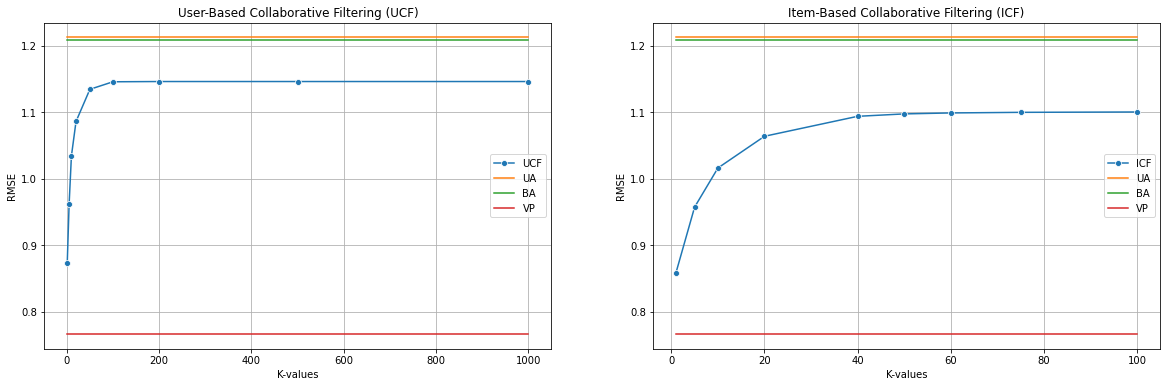

In [73]:
#Lineplots for all techniques with various K values compared with the above baselines (UA and BA)
fig = plt.figure(figsize = (20, 6))
fig.subplots_adjust(hspace=0.3, wspace = 0.2)

ax = fig.add_subplot(1, 2, 1)
ax_ucf = sns.lineplot(x = k_ucf, y = ucf_rmse_list, marker = 'o', ax = ax, legend = 'auto')
ax_ucf = sns.lineplot(x = k_ucf, y = ua_rmse, ax = ax)
ax_ucf = sns.lineplot(x = k_ucf, y = ba_rmse, ax = ax)
ax_ucf = sns.lineplot(x = k_ucf, y = vp_rmse, ax = ax)
ax_ucf.set(xlabel="K-values", ylabel = "RMSE")
ax_ucf.set_title('User-Based Collaborative Filtering (UCF)')
ax_ucf.legend(['UCF', 'UA', 'BA', 'VP'])
plt.grid()

ax = fig.add_subplot(1, 2, 2)
ax_icf = sns.lineplot(x = k_icf, y = icf_rmse_list, marker = 'o', ax = ax, legend = 'auto')
ax_icf = sns.lineplot(x = k_icf, y = ua_rmse, ax = ax)
ax_icf = sns.lineplot(x = k_icf, y = ba_rmse, ax = ax)
ax_icf = sns.lineplot(x = k_icf, y = vp_rmse, ax = ax)
ax_icf.set(xlabel="K-values", ylabel = "RMSE")
ax_icf.set_title('Item-Based Collaborative Filtering (ICF)')
ax_icf.legend(['ICF', 'UA', 'BA', 'VP'])
plt.grid()

plt.show()

Overall lineplot comparison of all recommendation system algorithms.
--------------------------------------------------------------------------------------------------------
**Lineplot explanation:**
* **VP**       = Value Propagation
* **UCF**      = User based Collaborative Filtering
* **ICF**      = Item-Based Collaborative Filtering
* **UA**       = User Average (baseline)
* **BA**       = Business Average (baseline)
* **RMSE**     = Root Mean Square Error
* **K-values** = K refers to how many similar Users(for UCF) or Businesses(for ICF) we use to make our predictions

**Remarks:**

* First thing we notice is that Value propagation algorithm gives by far the best prediction based on RMSE

* Secondly, User Average and Business Average baselines did the worst

* A big surprise is also that UCF and ICF algorithms are increasing logarithmicly and give their best predictions on K=1. This comes in contrast to what we would expect from this algorithms(logarithmic decrease with higher K-values). 
    - One explanation for this behavior may be the extreme pruning we did on the data
    - Another explanation(unlikely) may be the context of the data.



-------------------------------------------------------------------------------------
Down below are overall results of all algorithms with numbers.
------------------------------------------------------------------------------------------

In [74]:
#Print the results of all methods above as dataframes
import pandas as pd

data = {'K-UCF':  k_ucf,
        'UCF RMSE': ucf_rmse_list,
        'K-ICF': k_icf,
        'ICF RMSE': icf_rmse_list}

df_results = pd.DataFrame (data, columns = ['K-UCF', 'UCF RMSE', 'K-ICF', 'ICF RMSE'])

df_results

,K-UCF,UCF RMSE,K-ICF,ICF RMSE
0,1,0.873727,1,0.858635
1,5,0.961209,5,0.957268
2,10,1.034046,10,1.015984
3,20,1.085940,20,1.063681
4,50,1.134254,40,1.093688
5,100,1.145591,50,1.097314
6,200,1.145969,60,1.098753
7,500,1.145969,75,1.099665
8,1000,1.145969,100,1.100201


In [75]:
print("RMSE for User Average (UA) baseline: ", ua_rmse)
print("RMSE for Business Average (BA) baseline: ", ba_rmse)

RMSE for User Average (UA) baseline:  1.212190412301203
RMSE for Business Average (BA) baseline:  1.208374803331618


In [76]:
print("RMSE for Value Propagation algorithm is: ", vp_rmse)

RMSE for Value Propagation algorithm is:  0.7665752537787143


Overall the **smallest RMSE** and subsequently the **best performance** is achieved by **Value Propagation** algorithm.